In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

In [17]:
#%% load training data
allData = pd.read_csv('C:\\Users\\Administrator\\Desktop\\data.csv')
data = allData[allData['shot_made_flag'].notnull()].reset_index()

#%% add some temporal columns to the data
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date_DT'].dt.dayofweek
data['dayOfYear']    = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

# look at first couple of rows and verify that everything is good
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


Text(0.5, 1.0, '投篮位置')

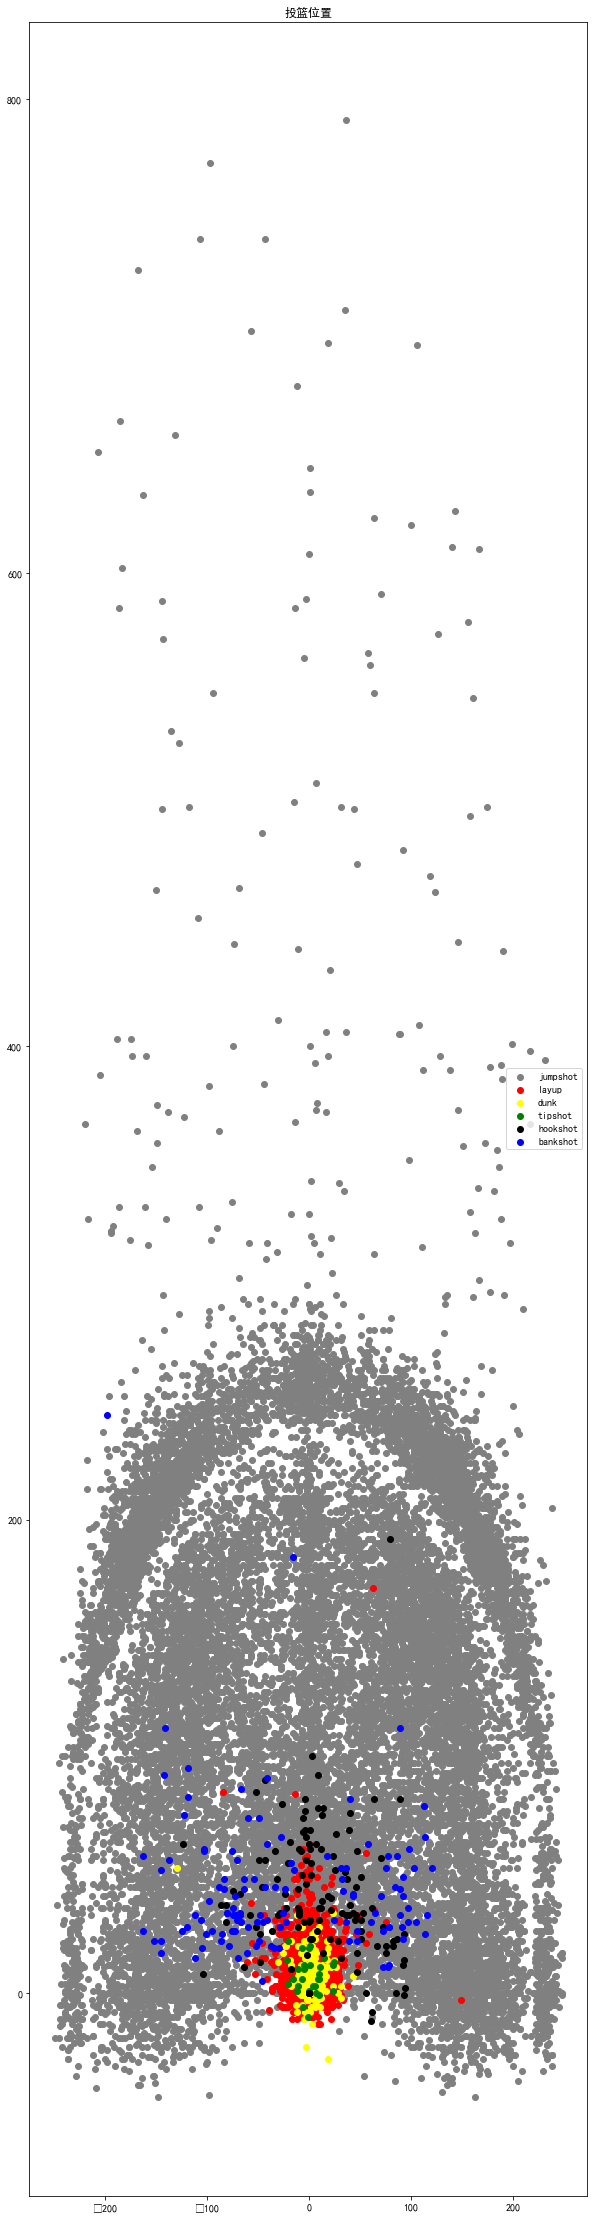

In [91]:
plt.figure(figsize=(10,400))
jumpshot = new_data[new_data['combined_shot_type']=='Jump Shot']
layup = new_data[new_data['combined_shot_type']=='Layup']
dunk = new_data[new_data['combined_shot_type']=='Dunk']
tipshot = new_data[new_data['combined_shot_type']=='Tip Shot']
hookshot = new_data[new_data['combined_shot_type']=='Hook Shot']
bankshot = new_data[new_data['combined_shot_type']=='Bank Shot']

plt.scatter(jumpshot.loc_x, jumpshot.loc_y, color='grey')
plt.scatter(layup.loc_x, layup.loc_y, color='red')
plt.scatter(dunk.loc_x, dunk.loc_y, color='yellow' )
plt.scatter(tipshot.loc_x, tipshot.loc_y, color='green')
plt.scatter(hookshot.loc_x, hookshot.loc_y, color='black')
plt.scatter(bankshot.loc_x, bankshot.loc_y, color='blue')
label=['jumpshot','layup','dunk','tipshot','hookshot','bankshot']
plt.legend(label,loc=7)
plt.title('投篮位置')

Text(0.5, 0, 'time [seconds from start of game]')

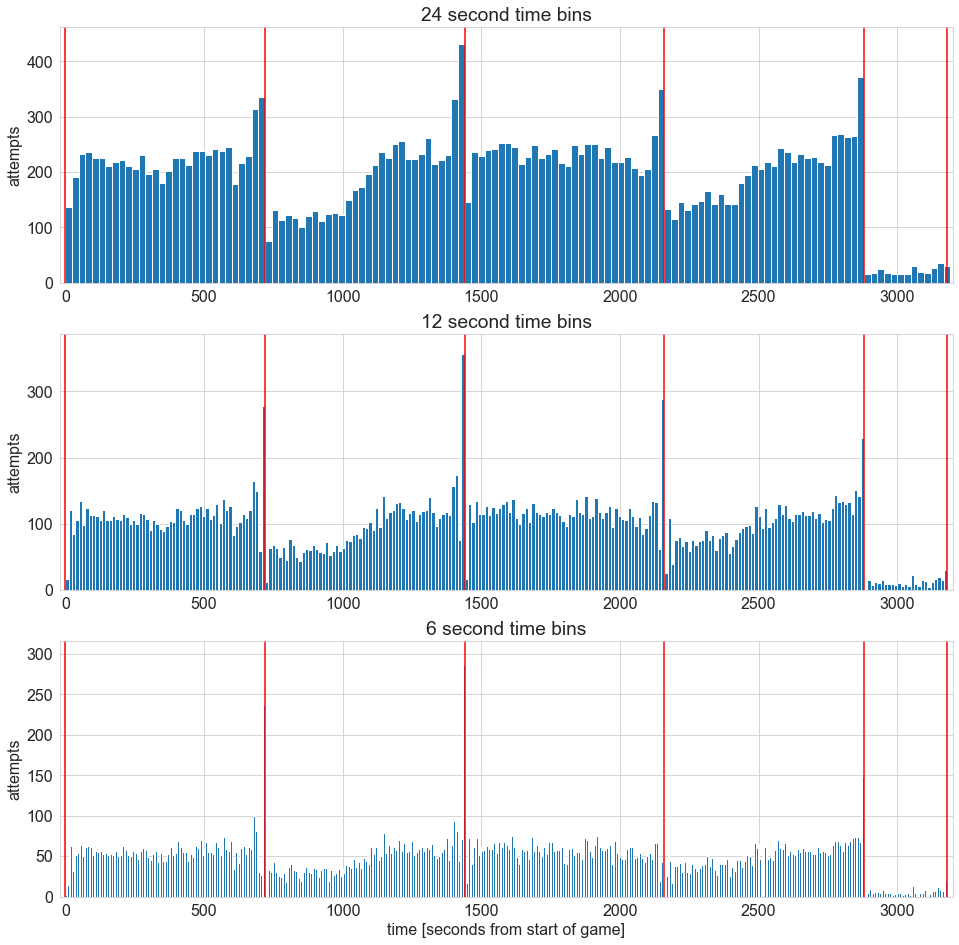

In [18]:
# plot the shot attempts as a function of time (from start of game) with several different binnings
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')

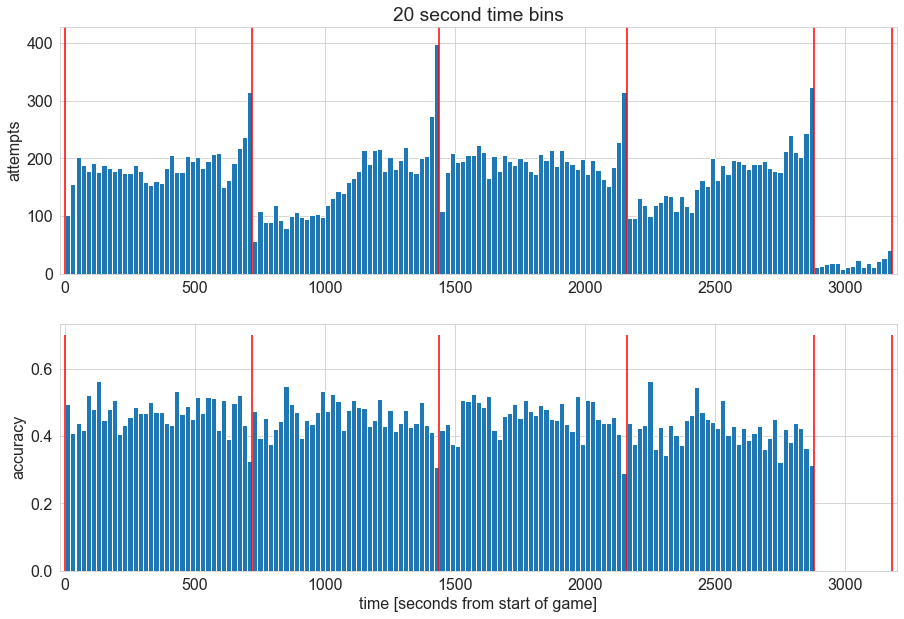

In [19]:
#%% plot the accuracy as a function of time
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16

binSizeInSeconds = 20
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag']==1,'secondsFromGameStart'], bins=timeBins)     
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # zero accuracy in bins that don't have enough samples

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])

plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts'); plt.title(str(binSizeInSeconds) + ' second time bins')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
plt.subplot(2,1,2); plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')

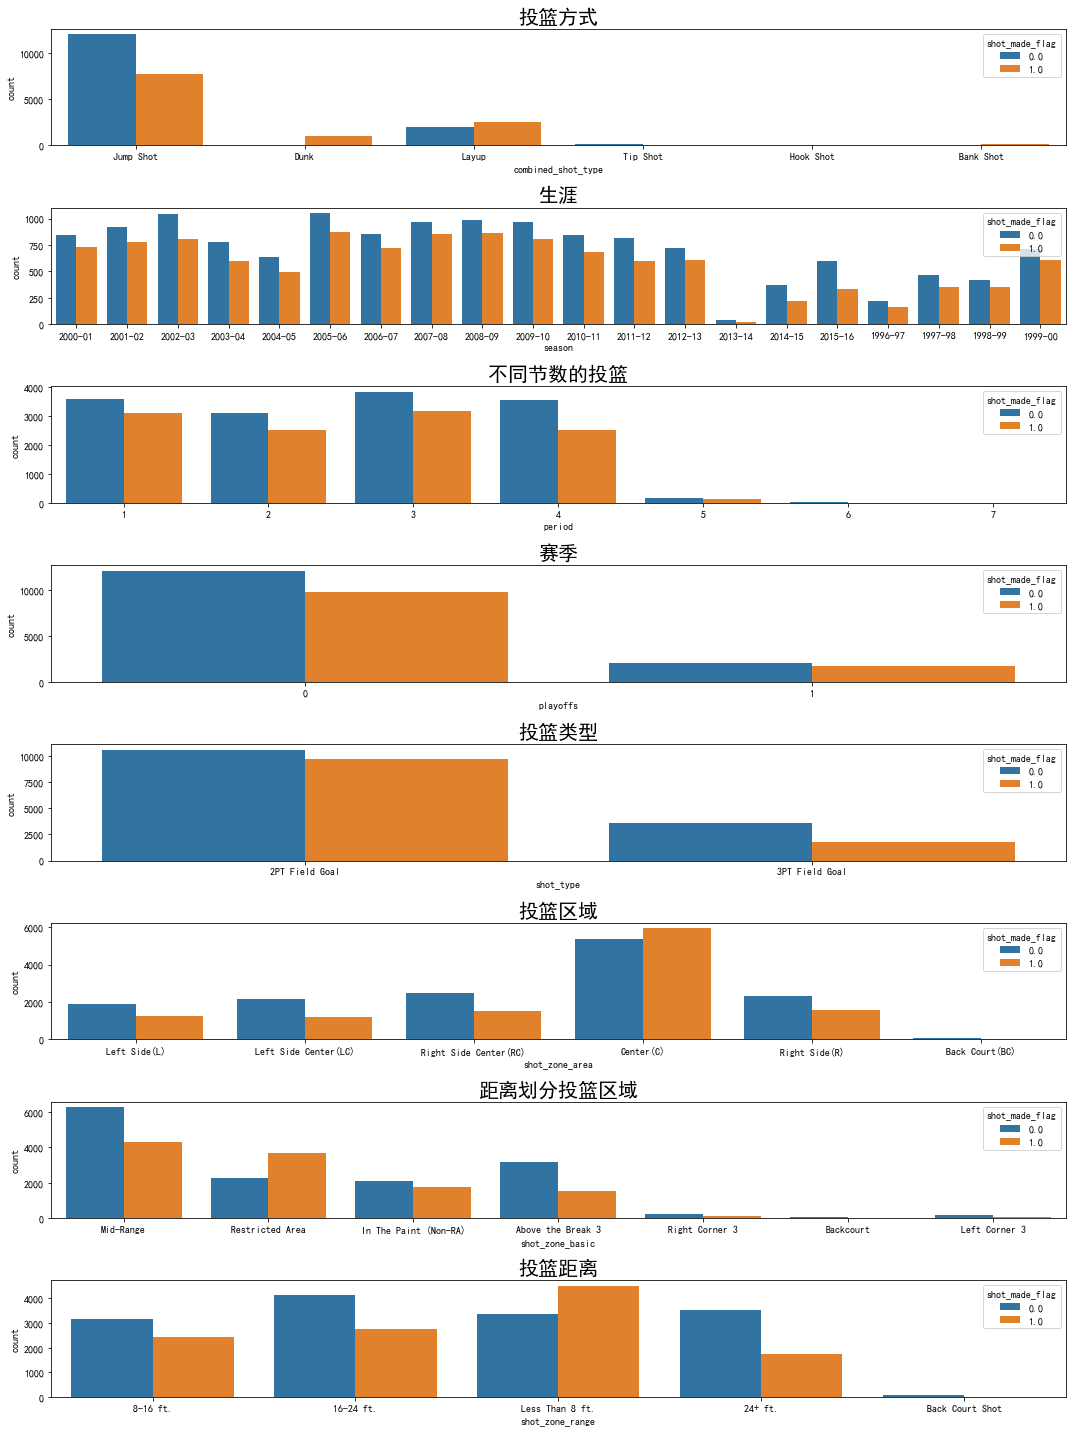

In [25]:
f, axarr = plt.subplots(8, figsize=(15, 20))
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=new_data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=new_data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=new_data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=new_data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=new_data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=new_data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=new_data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=new_data, ax=axarr[7])
axarr[0].set_title('投篮方式',fontsize=20)
axarr[1].set_title('生涯',fontsize=20)
axarr[2].set_title('不同节数的投篮',fontsize=20)
axarr[3].set_title('赛季',fontsize=20)
axarr[4].set_title('投篮类型',fontsize=20)
axarr[5].set_title('投篮区域',fontsize=20)
axarr[6].set_title('距离划分投篮区域',fontsize=20)
axarr[7].set_title('投篮距离',fontsize=20)
plt.tight_layout()
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

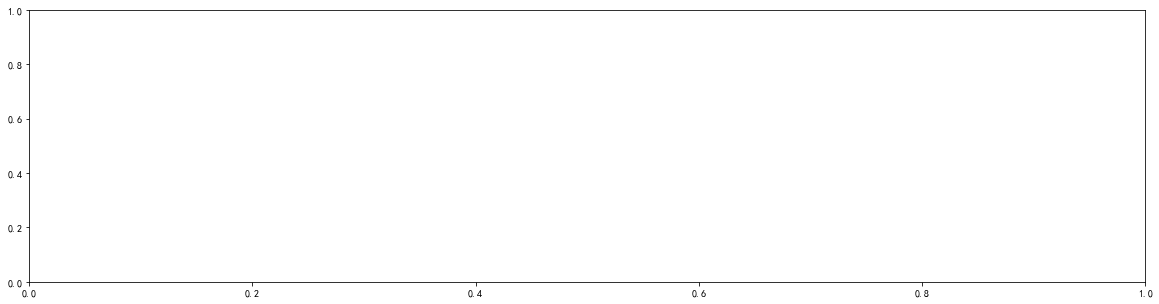

In [31]:
f, axarr = plt.subplots(1, figsize=(20, 5))
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=new_data, ax=axarr[1])

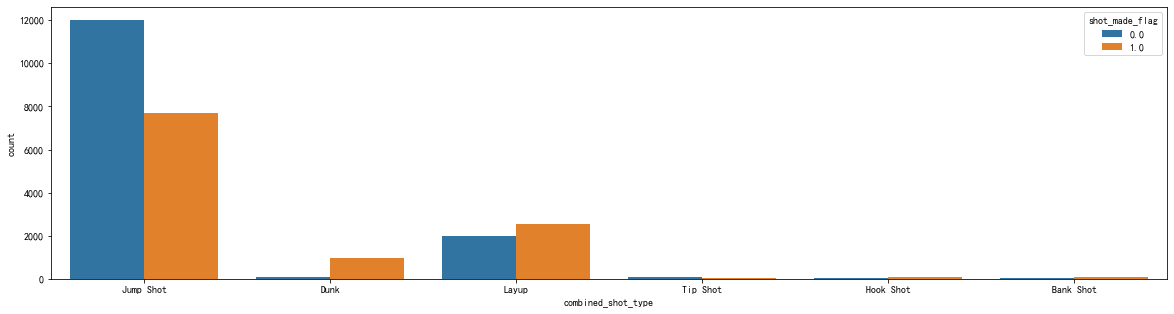

In [92]:
f, axarr = plt.subplots(1, figsize=(20, 5))
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=new_data, ax=axarr)

In [40]:
shooting = new_data[new_data['shot_made_flag']==1]['season'].value_counts()
list1 = season.tolist()
list2 = shooting.tolist()
list3 = season.tolist()
for i in range(len(list1)):
    list3[i]=list2[i]/list1[i]
hits_df=pd.Series(list3);
a = np.array([1,2,3,4,5,6])
plt.bar(a,hits_df,align = 'center')
plt.ylabel('field goal percentage',fontsize=12)
plt.xticks(a,('1996-97','1997-98','1998-99','1999-00','2000-01','2001-02','2002-03','2003-04','2004-05','2005-02','2006-07','2007-08','2008-09','2009-10','2010-11','2011-12','2012-13','2013-14','2014-15','2015-16'),fontsize=12)
plt.show()

NameError: name 'season' is not defined

In [35]:
data["season"] = data["season"].astype('category')

In [36]:
data["season"] 

0        2000-01
1        2000-01
2        2000-01
3        2000-01
4        2000-01
5        2000-01
6        2000-01
7        2000-01
8        2000-01
9        2000-01
10       2000-01
11       2000-01
12       2000-01
13       2000-01
14       2000-01
15       2000-01
16       2000-01
17       2000-01
18       2000-01
19       2000-01
20       2000-01
21       2000-01
22       2000-01
23       2000-01
24       2000-01
25       2000-01
26       2000-01
27       2000-01
28       2000-01
29       2000-01
          ...   
30667    1999-00
30668    1999-00
30669    1999-00
30670    1999-00
30671    1999-00
30672    1999-00
30673    1999-00
30674    1999-00
30675    1999-00
30676    1999-00
30677    1999-00
30678    1999-00
30679    1999-00
30680    1999-00
30681    1999-00
30682    1999-00
30683    1999-00
30684    1999-00
30685    1999-00
30686    1999-00
30687    1999-00
30688    1999-00
30689    1999-00
30690    1999-00
30691    1999-00
30692    1999-00
30693    1999-00
30694    1999-

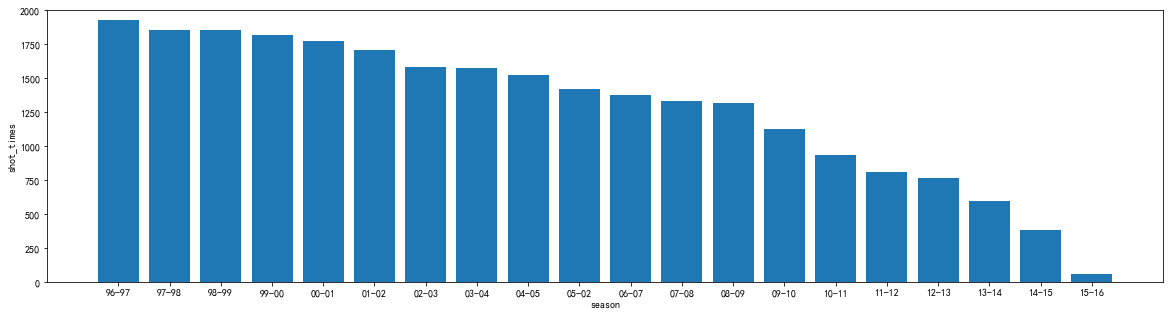

In [62]:
fig=plt.figure(figsize=(20,5))
season = new_data['season'].value_counts()
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.bar(a,season,align = 'center')
plt.xlabel('season')
plt.ylabel('shot_times')


plt.ylim(0,2000)

plt.xticks(a,('96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-02','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16'))
plt.show()

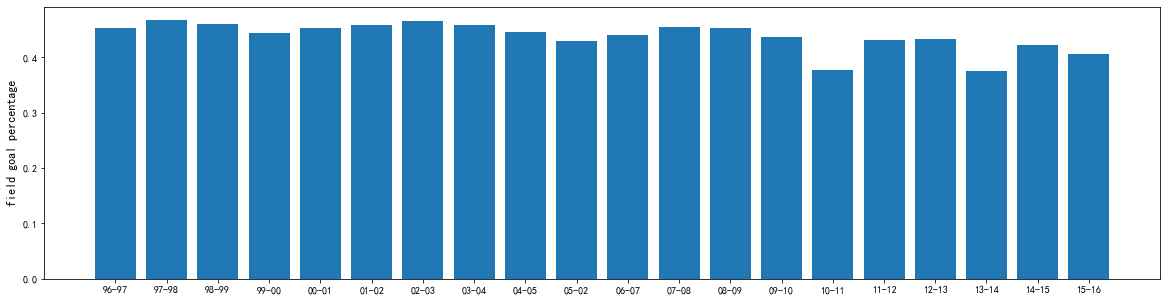

In [61]:
fig=plt.figure(figsize=(20,5))
shooting = new_data[new_data['shot_made_flag']==1]['season'].value_counts()
list1 = season.tolist()
list2 = shooting.tolist()
list3 = season.tolist()
for i in range(len(list1)):
    list3[i]=list2[i]/list1[i]
hits_df=pd.Series(list3);
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.bar(a,hits_df,align = 'center')
plt.ylabel('field goal percentage',fontsize=12)
plt.xticks(a,('96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-02','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16'))
plt.show()

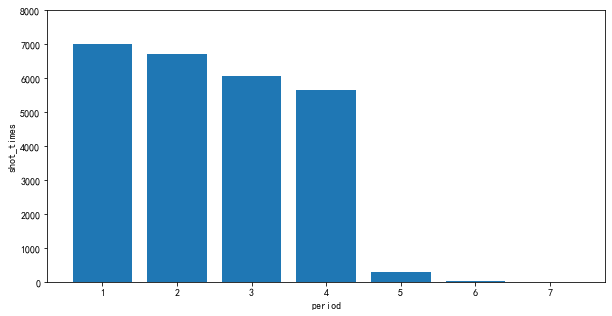

In [84]:
fig=plt.figure(figsize=(10,5))
period = new_data['period'].value_counts()
a = np.array([1,2,3,4,5,6,7])
plt.bar(a,period,align = 'center')
plt.xlabel('period')
plt.ylabel('shot_times')


plt.ylim(0,8000)

plt.xticks(a,('1','2','3','4','5','6','7'))
plt.show()

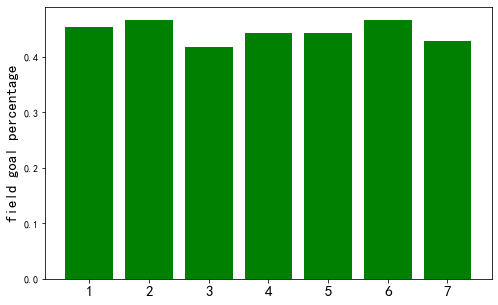

In [90]:
fig=plt.figure(figsize=(8,5))
shooting = new_data[new_data['shot_made_flag']==1]['period'].value_counts()
list1 = period.tolist()
list2 = shooting.tolist()
list3 = period.tolist()
for i in range(len(list1)):
    list3[i]=list2[i]/list1[i]
hits_df=pd.Series(list3);
a = np.array([1,2,3,4,5,6,7])
plt.bar(a,hits_df,align = 'center',color = 'g')
plt.ylabel('field goal percentage',fontsize=15)
plt.xticks(a,('1','2','3','4','5','6','7'),fontsize=15)
plt.show()

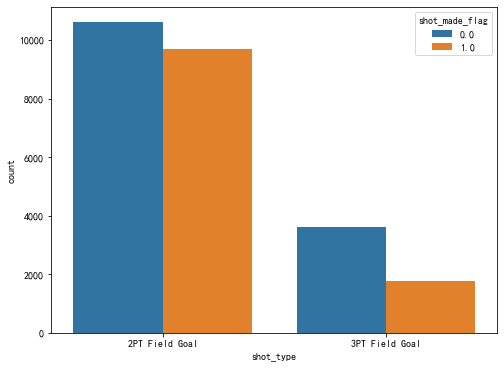

In [98]:
f, axarr = plt.subplots(1, figsize=(8, 6))
sns.countplot(x="shot_type", hue="shot_made_flag", data=new_data, ax=axarr)

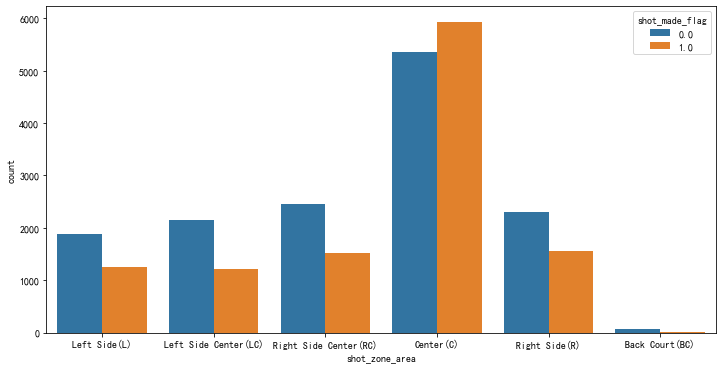

In [102]:
f, axarr = plt.subplots(1, figsize=(12, 6))
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=new_data, ax=axarr)


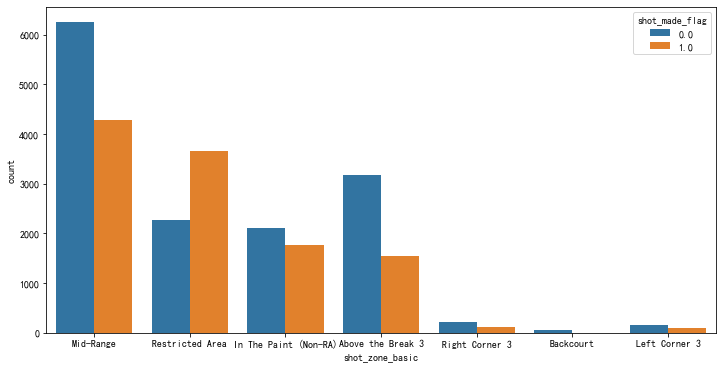

In [103]:
f, axarr = plt.subplots(1, figsize=(12, 6))
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=new_data, ax=axarr)


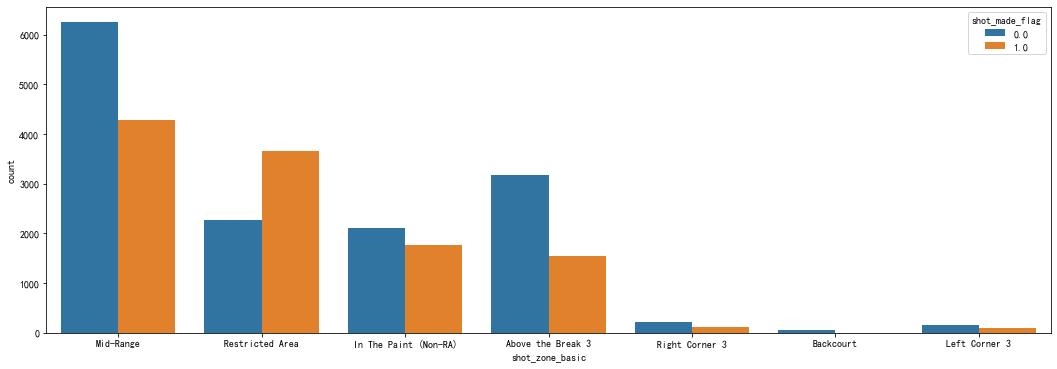

In [104]:
f, axarr = plt.subplots(1, figsize=(18, 6))
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=new_data, ax=axarr)


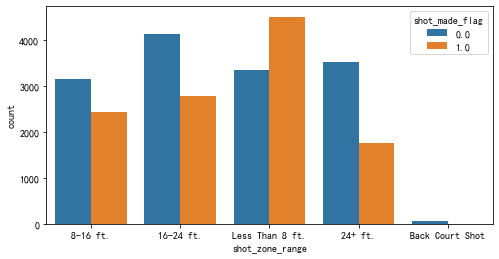

In [107]:
f, axarr = plt.subplots(1, figsize=(8, 4))
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=new_data, ax=axarr)


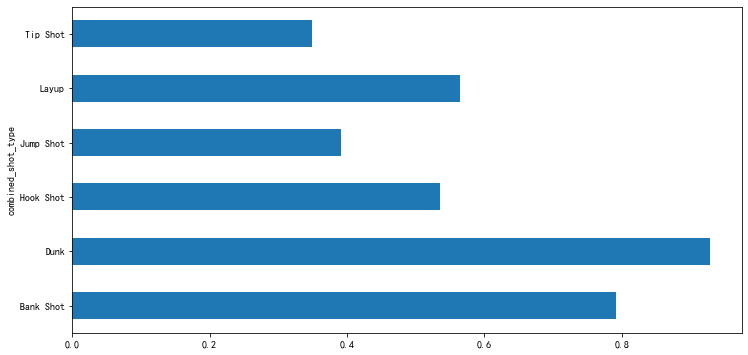

In [108]:
shot_type_acc = data['shot_made_flag'].groupby(data['combined_shot_type']).mean()
shot_type_acc.plot(kind='barh', figsize=(12, 6))

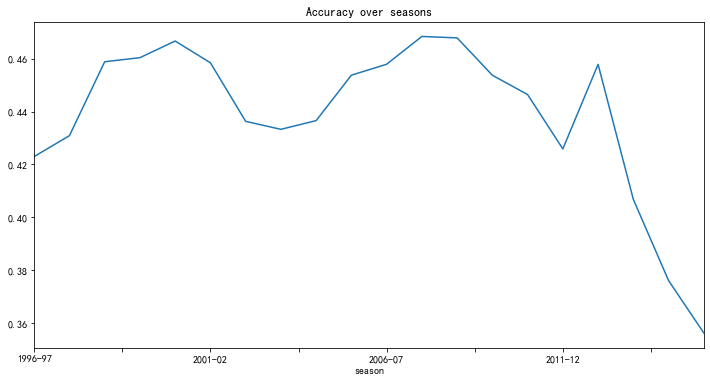

In [109]:
season_acc = data['shot_made_flag'].groupby(data['season']).mean()
season_acc.plot(figsize=(12, 6), title='Accuracy over seasons')


In [3]:
#设置字体
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
#读取csv文件
data=pd.read_csv("data.csv")
#输出前5条数据
print(data.head())
#将shot_made_flag为空的数据清除
new_data = data[data['shot_made_flag'].notnull()]

FileNotFoundError: [Errno 2] File b'data.csv' does not exist: b'data.csv'

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import mpl  

In [4]:
#设置字体
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
#读取csv文件
data=pd.read_csv("C:\\Users\\Administrator\\Desktop\\data.csv")
#输出前5条数据
print(data.head())
#将shot_made_flag为空的数据清除
new_data = data[data['shot_made_flag'].notnull()]

         action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  ...       shot_type  \
0    167     72 -118.1028                 10       1  ...  2PT Field Goal   
1   -157      0 -118.4268                 10       1  ...  2PT Field Goal   
2   -101    135 -118.3708                  7       1  ...  2PT Field Goal   
3    138    175 -118.1318                  6       1  ...  2PT Field Goal   
4      0      0 -118.2698                  6       2  ...  2PT Field Goal   

          shot_zone_area  shot_zone_basic  shot_zone_range     team_id  \


In [5]:
raw.head()

NameError: name 'raw' is not defined

In [6]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

In [9]:
data = pd.read_csv('C:\\Users\\Administrator\\Desktop\\data.csv')

data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [13]:
data.describe(include=['number'])

,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437
std,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000


In [15]:
data.describe(include=['object', 'category'])

,action_type,combined_shot_type,game_event_id,game_id,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,620,1559,7,2,20,2.0,2,6,7,5,1,1,1559,74,33
top,Jump Shot,Jump Shot,2,21501228,3,0,2005-06,0.0,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,132,50,8296,26198,2318,14232.0,24271,13455,12625,9398,30697,30697,50,1020,1978


In [12]:
data.dtypes

action_type             object
combined_shot_type    category
game_event_id         category
game_id               category
lat                    float64
loc_x                    int64
loc_y                    int64
lon                    float64
minutes_remaining        int64
period                  object
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area          object
shot_zone_basic         object
shot_zone_range         object
team_id               category
team_name               object
game_date               object
matchup                 object
opponent                object
dtype: object